In [18]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [19]:
import torch
torch.cuda.empty_cache()

## Downloading dataset

In [20]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')


Using downloaded and verified file: ./cifar10.tgz


## Printing classes of Dataset

In [21]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/tinyTrain")
print(classes)


['tinyTrain', 'train', 'test']
['deer', 'truck', 'ship', 'horse', 'bird', 'airplane', 'frog', 'automobile', 'dog', 'cat']


## Applying Data Augmentation

In [22]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                          
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                          #tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [23]:
train_ds=ImageFolder(data_dir+'/tinyTrain',train_tfms)
valid_ds=ImageFolder(data_dir+'/test',valid_tfms)


In [24]:
batch_size=100

In [25]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_loader=DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=2)

## Selecting GPU

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
    
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) 
        
    

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
train_dl=DeviceDataLoader(train_loader,device)
valid_dl=DeviceDataLoader(val_loader,device)

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model

In [30]:
class block(nn.Module):
    def __init__(self,in_channels=64,intermediate_channels=64,identity_downsample=None,stride=1):
        super(block,self).__init__()
        self.conv1=nn.Conv2d(in_channels,intermediate_channels,kernel_size=3,stride=stride,
                             padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(intermediate_channels)
        self.conv2=nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,
                             stride=1,
                             padding=1,
                             bias=False
                            )
        self.bn2=nn.BatchNorm2d(intermediate_channels)
        self.relu=nn.ReLU()
        self.identity_downsample=identity_downsample
        self.stride=stride
        
    def forward(self,x):
        identity=x.clone()
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        
        
        if self.identity_downsample is not None:
            identity=self.identity_downsample(identity)
        
       
        x+=identity
        
        x=self.relu(x)
        return x
    
    
    
class ResNet(ImageClassificationBase):
    def __init__(self,block,layers,image_channels,num_classes,drop1,drop2):
        super(ResNet,self).__init__()
        self.in_channels=64
        self.conv1=nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.layer1=self._make_layer( block,layers[0],intermediate_channels=64,stride=1)
        self.layer2=self._make_layer(block,layers[1],intermediate_channels=128,stride=2)
        self.layer3=self._make_layer(block,layers[2],intermediate_channels=256,stride=2)
        self.layer4=self._make_layer(block,layers[3],intermediate_channels=512,stride=2)
        
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512 , num_classes )
        self.dropout1=nn.Dropout(drop1)
        self.dropout2=nn.Dropout(drop2)
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.dropout1(x)
        x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=x.reshape(x.shape[0],-1)
        x=self.dropout2(x)
        x=self.fc(x)
        
        
        x=F.softmax(x,dim=1)
        
        return x
    
    def _make_layer(self,block, num_residual_blocks,intermediate_channels,stride):
        identity_downsample=None
        layers=[]
        
        #if stride!=1 or self.in_channels!=intermediate_channels:
        identity_downsample=nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                intermediate_channels,
                kernel_size=1,
                stride=stride,
                bias=False
            ),
            nn.BatchNorm2d(intermediate_channels),
            
        )
        
        layers.append(
            block(self.in_channels,intermediate_channels,identity_downsample,stride)
        )
        
        self.in_channels=intermediate_channels
        
        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels,intermediate_channels))
            
        
        return nn.Sequential(*layers)
    

    
def ResNet18(img_channel=3,num_classes=10,i=0,j=0):
    return ResNet(block,[2,2,2,2],img_channel,num_classes,i,j)


model=ResNet18(img_channel=3,num_classes=10,i=0,j=0)

    
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_s

In [31]:
model = to_device(model, device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_s

In [32]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Hyperparameters

In [33]:
epochs = 250
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
history=[]

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00040, train_loss: 2.1794, val_loss: 2.1531, val_acc: 0.3025
Epoch [1], last_lr: 0.00042, train_loss: 2.1276, val_loss: 2.1057, val_acc: 0.3512
Epoch [2], last_lr: 0.00044, train_loss: 2.1019, val_loss: 2.0679, val_acc: 0.3857
Epoch [3], last_lr: 0.00047, train_loss: 2.0909, val_loss: 2.1238, val_acc: 0.3319
Epoch [4], last_lr: 0.00050, train_loss: 2.0931, val_loss: 2.0964, val_acc: 0.3584
Epoch [5], last_lr: 0.00055, train_loss: 2.0743, val_loss: 2.0966, val_acc: 0.3589
Epoch [6], last_lr: 0.00060, train_loss: 2.0873, val_loss: 2.0710, val_acc: 0.3868
Epoch [7], last_lr: 0.00067, train_loss: 2.0815, val_loss: 2.1036, val_acc: 0.3529
Epoch [8], last_lr: 0.00074, train_loss: 2.0726, val_loss: 2.0869, val_acc: 0.3712
Epoch [9], last_lr: 0.00081, train_loss: 2.0801, val_loss: 2.0560, val_acc: 0.4012
Epoch [10], last_lr: 0.00090, train_loss: 2.0658, val_loss: 2.0964, val_acc: 0.3568
Epoch [11], last_lr: 0.00099, train_loss: 2.0804, val_loss: 2.0697, val_acc: 0.3846
Ep

Epoch [98], last_lr: 0.00954, train_loss: 1.9712, val_loss: 1.9872, val_acc: 0.4716
Epoch [99], last_lr: 0.00950, train_loss: 1.9885, val_loss: 2.0068, val_acc: 0.4512
Epoch [100], last_lr: 0.00947, train_loss: 1.9723, val_loss: 1.9677, val_acc: 0.4900
Epoch [101], last_lr: 0.00942, train_loss: 1.9535, val_loss: 1.9918, val_acc: 0.4665
Epoch [102], last_lr: 0.00938, train_loss: 1.9654, val_loss: 2.0050, val_acc: 0.4539
Epoch [103], last_lr: 0.00934, train_loss: 1.9683, val_loss: 2.0094, val_acc: 0.4480
Epoch [104], last_lr: 0.00929, train_loss: 1.9663, val_loss: 2.0276, val_acc: 0.4295
Epoch [105], last_lr: 0.00925, train_loss: 1.9527, val_loss: 1.9782, val_acc: 0.4787
Epoch [106], last_lr: 0.00920, train_loss: 1.9630, val_loss: 1.9644, val_acc: 0.4905
Epoch [107], last_lr: 0.00915, train_loss: 1.9429, val_loss: 1.9797, val_acc: 0.4778
Epoch [108], last_lr: 0.00910, train_loss: 1.9375, val_loss: 1.9488, val_acc: 0.5076
Epoch [109], last_lr: 0.00905, train_loss: 1.9407, val_loss: 1.9957

Epoch [195], last_lr: 0.00217, train_loss: 1.7776, val_loss: 1.8345, val_acc: 0.6247
Epoch [196], last_lr: 0.00210, train_loss: 1.7826, val_loss: 1.8195, val_acc: 0.6406
Epoch [197], last_lr: 0.00202, train_loss: 1.7806, val_loss: 1.8206, val_acc: 0.6377
Epoch [198], last_lr: 0.00195, train_loss: 1.7750, val_loss: 1.8267, val_acc: 0.6318
Epoch [199], last_lr: 0.00188, train_loss: 1.7713, val_loss: 1.8193, val_acc: 0.6392
Epoch [200], last_lr: 0.00181, train_loss: 1.7654, val_loss: 1.8134, val_acc: 0.6464
Epoch [201], last_lr: 0.00174, train_loss: 1.7677, val_loss: 1.8130, val_acc: 0.6454
Epoch [202], last_lr: 0.00168, train_loss: 1.7654, val_loss: 1.8123, val_acc: 0.6456
Epoch [203], last_lr: 0.00161, train_loss: 1.7639, val_loss: 1.8151, val_acc: 0.6441
Epoch [204], last_lr: 0.00154, train_loss: 1.7643, val_loss: 1.8147, val_acc: 0.6438
Epoch [205], last_lr: 0.00148, train_loss: 1.7589, val_loss: 1.8150, val_acc: 0.6452
Epoch [206], last_lr: 0.00142, train_loss: 1.7588, val_loss: 1.80

## Plotting

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

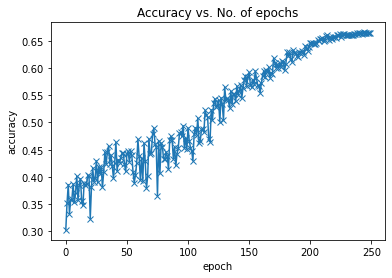

In [36]:
plot_accuracies(history)

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

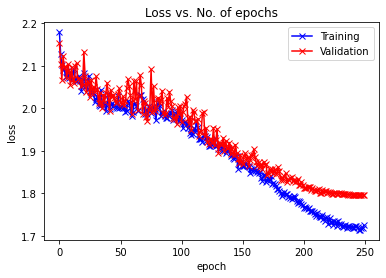

In [38]:
plot_losses(history)

In [39]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

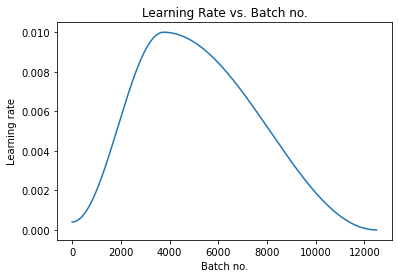

In [40]:
plot_lrs(history)

## Testing model

In [41]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


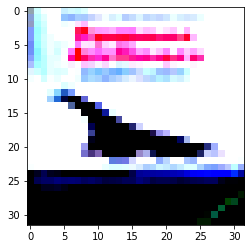

In [42]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


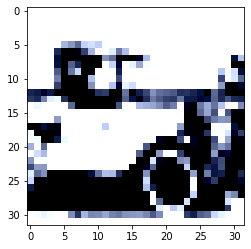

In [43]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


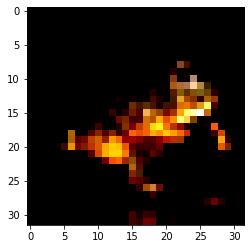

In [44]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))